In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
import re
import lfrData

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
G_lfr=nx.Graph()
data,labels=lfrData.load_data(0.1)

for index,item in enumerate(labels):
    G_lfr.add_node(index+1,value=item)
for item in data:
    G_lfr.add_edge(*item)
B_lfr = nx.modularity_matrix(G_lfr)

In [3]:
c_attributes = nx.get_node_attributes(G_lfr,'value')
print(c_attributes)

{1: 2, 2: 4, 3: 1, 4: 4, 5: 2, 6: 2, 7: 1, 8: 4, 9: 3, 10: 2, 11: 4, 12: 1, 13: 1, 14: 1, 15: 3, 16: 1, 17: 1, 18: 1, 19: 4, 20: 4, 21: 3, 22: 2, 23: 1, 24: 3, 25: 4, 26: 4, 27: 4, 28: 2, 29: 1, 30: 2, 31: 3, 32: 4, 33: 3, 34: 3, 35: 1, 36: 3, 37: 1, 38: 4, 39: 2, 40: 3, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 1, 47: 3, 48: 2, 49: 2, 50: 1, 51: 1, 52: 2, 53: 1, 54: 4, 55: 2, 56: 3, 57: 4, 58: 3, 59: 4, 60: 2, 61: 4, 62: 1, 63: 4, 64: 3, 65: 3, 66: 2, 67: 2, 68: 1, 69: 3, 70: 2, 71: 2, 72: 3, 73: 1, 74: 3, 75: 4, 76: 4, 77: 3, 78: 4, 79: 4, 80: 1, 81: 2, 82: 3, 83: 4, 84: 1, 85: 1, 86: 4, 87: 3, 88: 4, 89: 4, 90: 2, 91: 3, 92: 4, 93: 3, 94: 4, 95: 3, 96: 1, 97: 1, 98: 4, 99: 1, 100: 1, 101: 1, 102: 3, 103: 3, 104: 2, 105: 3, 106: 1, 107: 3, 108: 1, 109: 4, 110: 4, 111: 2, 112: 1, 113: 3, 114: 1, 115: 4, 116: 3, 117: 2, 118: 2, 119: 2, 120: 3, 121: 2, 122: 1, 123: 3, 124: 3, 125: 2, 126: 2, 127: 4, 128: 4}


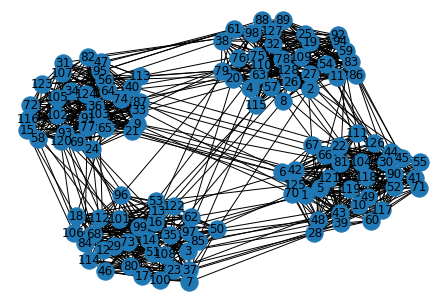

In [4]:
nx.draw(G_lfr,with_labels=True)

In [5]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [6]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.01)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        return encoder,reconstructed

In [7]:
learning_rate = 1e-4

In [8]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=128)
model2=AE(hidden_layers=32,in_layers=64)
model3=AE(hidden_layers=16,in_layers=32)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=128, out_features=64, bias=True)
  (encoder_output_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_output_layer): Linear(in_features=64, out_features=128, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)


In [9]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [10]:
B_lfr=np.asarray(B_lfr,dtype=np.float64)
inputs=torch.from_numpy(B_lfr)
targets=torch.from_numpy(B_lfr)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist=train_model(5000,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist=train_model(5000,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
encoder,hist=train_model(5000,train_dl,model3,optimizer3)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

epoch : 1/5000, recon loss = 0.11800214
epoch : 2/5000, recon loss = 0.11775517
epoch : 3/5000, recon loss = 0.11751104
epoch : 4/5000, recon loss = 0.11726974
epoch : 5/5000, recon loss = 0.11703121
epoch : 6/5000, recon loss = 0.11679543
epoch : 7/5000, recon loss = 0.11656232
epoch : 8/5000, recon loss = 0.11633183
epoch : 9/5000, recon loss = 0.11610390
epoch : 10/5000, recon loss = 0.11587843
epoch : 11/5000, recon loss = 0.11565536
epoch : 12/5000, recon loss = 0.11543459
epoch : 13/5000, recon loss = 0.11521603
epoch : 14/5000, recon loss = 0.11499958
epoch : 15/5000, recon loss = 0.11478513
epoch : 16/5000, recon loss = 0.11457259
epoch : 17/5000, recon loss = 0.11436185
epoch : 18/5000, recon loss = 0.11415279
epoch : 19/5000, recon loss = 0.11394531
epoch : 20/5000, recon loss = 0.11373928
epoch : 21/5000, recon loss = 0.11353459
epoch : 22/5000, recon loss = 0.11333112
epoch : 23/5000, recon loss = 0.11312876
epoch : 24/5000, recon loss = 0.11292738
epoch : 25/5000, recon lo

In [11]:
B_lfr_X=encoder.detach().numpy()

In [12]:
print(type(B_lfr_X),B_lfr_X)

<class 'numpy.ndarray'> [[ 0.08069956  0.36323175 -0.42218375 ... -0.40853587  0.39204374
  -0.65726537]
 [-0.8358271  -0.35296428 -0.5585245  ...  0.14969492  0.00375882
   0.2814461 ]
 [ 0.02365186 -0.04324703  0.4433055  ...  0.75379694 -0.520814
  -0.37909293]
 ...
 [ 0.6234821   0.35783666 -0.5403329  ... -0.0528755   0.34030277
  -0.57037544]
 [-0.63963866 -0.7526391   0.14150158 ...  0.31021217 -0.1727194
  -0.3240635 ]
 [-0.70415705  0.62732273 -0.26224566 ...  0.7301753   0.7368041
  -0.27798286]]


In [15]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=614)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_

c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[2 3 0 3 2 2 0 3 1 2 3 0 0 0 1 0 0 0 3 3 1 2 0 0 3 3 3 2 0 2 1 3 1 2 0 0 0
 3 2 1 2 2 2 2 2 0 1 2 2 0 0 2 0 3 2 1 3 1 3 2 3 0 3 1 0 2 2 0 1 2 2 1 0 1
 3 3 1 3 3 0 2 1 3 0 0 3 1 3 3 2 1 3 1 3 1 1 0 3 0 0 0 1 1 2 1 0 1 0 3 3 2
 0 1 0 3 1 2 2 2 1 2 0 1 1 2 2 3 3]
[2 4 1 4 2 2 1 4 3 2 4 1 1 1 3 1 1 1 4 4 3 2 1 3 4 4 4 2 1 2 3 4 3 3 1 3 1
 4 2 3 2 2 2 2 2 1 3 2 2 1 1 2 1 4 2 3 4 3 4 2 4 1 4 3 3 2 2 1 3 2 2 3 1 3
 4 4 3 4 4 1 2 3 4 1 1 4 3 4 4 2 3 4 3 4 3 1 1 4 1 1 1 3 3 2 3 1 3 1 4 4 2
 1 3 1 4 3 2 2 2 3 2 1 3 3 2 2 4 4]


0.8936085250941338

In [14]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_lfr_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_lfr,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.7035893918035184
Epoch:2 2 0.7386008799622908
Epoch:3 3 0.7478499659194352
Epoch:4 4 0.7486762133930164
Epoch:5 5 0.7800866429310537
Epoch:6 6 0.8157380940709092
Epoch:7 6 0.8157380940709092
Epoch:8 6 0.8157380940709092
Epoch:9 6 0.8157380940709092
Epoch:10 6 0.8157380940709092
Epoch:11 6 0.8157380940709092
Epoch:12 6 0.8157380940709092
Epoch:13 6 0.8157380940709092
Epoch:14 6 0.8157380940709092
Epoch:15 6 0.8157380940709092
Epoch:16 6 0.8157380940709092
Epoch:17 6 0.8157380940709092
Epoch:18 6 0.8157380940709092
Epoch:19 6 0.8157380940709092
Epoch:20 6 0.8157380940709092
Epoch:21 6 0.8157380940709092
Epoch:22 6 0.8157380940709092
Epoch:23 6 0.8157380940709092
Epoch:24 6 0.8157380940709092
Epoch:25 6 0.8157380940709092
Epoch:26 6 0.8157380940709092
Epoch:27 6 0.8157380940709092
Epoch:28 6 0.8157380940709092
Epoch:29 6 0.8157380940709092
Epoch:30 6 0.8157380940709092
Epoch:31 6 0.8157380940709092
Epoch:32 6 0.8157380940709092
Epoch:33 6 0.8157380940709092
Epoch:34 34 0.81573

In [17]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=614)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_
labels_dict={0:[],1:[],2:[],3:[]}
for index,item in enumerate(X_ae):
    labels_dict[item].append(index+1)
print(labels_dict)

{0: [3, 7, 12, 13, 14, 16, 17, 18, 23, 24, 29, 35, 36, 37, 46, 50, 51, 53, 62, 65, 68, 73, 80, 84, 85, 97, 99, 100, 101, 106, 108, 112, 114, 122], 1: [9, 15, 21, 31, 33, 40, 47, 56, 58, 64, 69, 72, 74, 77, 82, 87, 91, 93, 95, 96, 102, 103, 105, 107, 113, 116, 120, 123, 124], 2: [1, 5, 6, 10, 22, 28, 30, 34, 39, 41, 42, 43, 44, 45, 48, 49, 52, 55, 60, 66, 67, 70, 71, 81, 90, 104, 111, 117, 118, 119, 121, 125, 126], 3: [2, 4, 8, 11, 19, 20, 25, 26, 27, 32, 38, 54, 57, 59, 61, 63, 75, 76, 78, 79, 83, 86, 88, 89, 92, 94, 98, 109, 110, 115, 127, 128]}


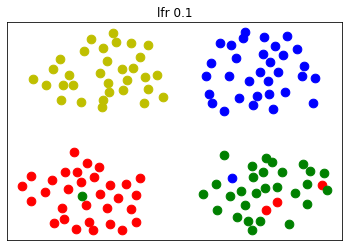

In [27]:
G=G_lfr
pos=nx.spring_layout(G)
# print(pos)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[0],node_color='r',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[1],node_color='g',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[2],node_color='b',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[3],node_color='y',node_size=75)

plt.title('lfr 0.1')
plt.show()